In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parent  # 找出根目錄：Path.cwd()找出現在所在目錄(/run).parent(上一層是notebook).parent(再上層一層business_district_discovery)
print(project_root)
sys.path.append(str(project_root))

from matplotlib.font_manager import fontManager
import matplotlib as mlp
FONT_PATH = project_root / "ChineseFont.ttf"
fontManager.addfont(str(FONT_PATH))
mlp.rcParams["font.family"] = "ChineseFont"

c:\labs\geo-grid


In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from libpysal.weights import Queen, Rook, DistanceBand
from esda.moran import Moran
from esda.moran import Moran, Moran_Local
from esda.getisord import G_Local
from scipy.spatial import cKDTree
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from functools import wraps
import logging
import math
from tqdm import tqdm

import contextily as ctx 
import seaborn as sns
from branca.colormap import LinearColormap
import matplotlib.colors as colors
from matplotlib.patches import Patch

import warnings
warnings.filterwarnings('ignore')



c:\labs\geo-grid\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 商業區中心識別系統
class AnalysisError(Exception):
    """自定義分析錯誤類"""
    pass

def handle_analysis_error(func):
    """錯誤處理裝飾器"""
    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            error_msg = f"{func.__name__} 失敗: {str(e)}"
            logging.error(error_msg)
            raise AnalysisError(error_msg)
    return wrapper

class CommercialCenterIdentifier:
    """
    改進版商業中心識別系統
    結合多種空間分析方法識別城市中的商業集聚區域
    """
    
    def __init__(self, cell_size=100):
        """
        初始化商業中心識別系統
        
        Parameters:
        cell_size: int, 網格大小(米)，預設100米
        """
        self.cell_size = cell_size
        self.base_weights = {
            '便利商店': 0.1,
            '超級市場': 0.3,
            '大型量販店': 1.0
        }
        
        # 設置日誌
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        
    @handle_analysis_error
    def load_poi_from_csv(self, csv_path, x_col='longitude', y_col='latitude', 
                         type_col='type', crs='EPSG:4326'):
        """
        從CSV檔案載入POI數據並轉換為GeoDataFrame
        
        Parameters:
        csv_path: str, CSV檔案路徑
        x_col: str, 經度欄位名稱
        y_col: str, 緯度欄位名稱
        type_col: str, 零售類型欄位名稱
        crs: str, 座標參考系統
        
        Returns:
        GeoDataFrame, 包含POI點位的地理數據框架
        """
        try:
            # 讀取CSV檔案
            logging.info(f"正在讀取CSV檔案: {csv_path}")
            df = pd.read_csv(csv_path)
            
            # 資料驗證
            self._validate_poi_data(df, x_col, y_col, type_col)
            
            # 處理缺失值
            df = self._handle_missing_values(df, [x_col, y_col, type_col])
            
            # 創建GeoDataFrame
            geometry = [Point(xy) for xy in zip(df[x_col], df[y_col])]
            gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)
            
            # 轉換投影
            gdf = gdf.to_crs('EPSG:3857')
            
            # 添加唯一識別碼
            gdf['poi_id'] = range(len(gdf))
            
            logging.info(f"成功載入並轉換 {len(gdf)} 筆POI數據至EPSG:3857座標系統")
            
            return gdf
            
        except Exception as e:
            logging.error(f"載入POI數據時發生錯誤: {str(e)}")
            raise
            
    def _validate_poi_data(self, df, x_col, y_col, type_col):
        """驗證POI數據的有效性"""
        # 檢查必要欄位
        required_cols = [x_col, y_col]
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"缺少必要的欄位: {missing_cols}")
        
        # 驗證經緯度範圍
        if not df[x_col].between(-180, 180).all():
            raise ValueError("經度值超出有效範圍 (-180 到 180)")
        if not df[y_col].between(-90, 90).all():
            raise ValueError("緯度值超出有效範圍 (-90 到 90)")
            
        # 驗證類型欄位
        if type_col not in df.columns:
            logging.warning(f"找不到類型欄位 '{type_col}'，將設置為'unknown'")
            
    def _handle_missing_values(self, df, columns):
        """處理缺失值"""
        initial_count = len(df)
        
        # 移除關鍵欄位中的缺失值
        df = df.dropna(subset=columns)
        
        removed_count = initial_count - len(df)
        if removed_count > 0:
            logging.warning(f"已移除 {removed_count} 筆含有缺失值的記錄")
            
        return df
    
    @handle_analysis_error
    def create_grid(self, admin_boundaries):
        """
        將研究區域劃分為規則網格，並確保網格與行政區域正確對齊
        
        Parameters:
        admin_boundaries: GeoDataFrame，行政區域邊界
        
        Returns:
        GeoDataFrame，包含網格的幾何資訊
        """
        logging.info("開始創建研究區域網格...")

        # 確保座標系統一致性
        if admin_boundaries.crs != 'EPSG:3857':
            logging.info("轉換行政區域邊界至EPSG:3857座標系統")
            admin_boundaries = admin_boundaries.to_crs('EPSG:3857')
        
        try:
            # 計算研究區域邊界
            bounds = admin_boundaries.total_bounds
            x_min, y_min, x_max, y_max = bounds
            
            # 調整網格範圍以確保完整覆蓋
            x_min = np.floor(x_min / self.cell_size) * self.cell_size
            y_min = np.floor(y_min / self.cell_size) * self.cell_size
            x_max = np.ceil(x_max / self.cell_size) * self.cell_size
            y_max = np.ceil(y_max / self.cell_size) * self.cell_size
            
            # 創建網格坐標
            x_coords = np.arange(x_min, x_max + self.cell_size, self.cell_size)
            y_coords = np.arange(y_min, y_max + self.cell_size, self.cell_size)
            
            # 生成網格
            grid_cells = []
            grid_info = []  # 儲存網格資訊
            
            for i, x in enumerate(x_coords[:-1]):
                for j, y in enumerate(y_coords[:-1]):
                    # 創建網格多邊形
                    cell = Polygon([
                        (x, y),
                        (x + self.cell_size, y),
                        (x + self.cell_size, y + self.cell_size),
                        (x, y + self.cell_size)
                    ])
                    grid_cells.append(cell)
                    
                    # 記錄網格索引
                    grid_info.append({
                        'grid_id': f'grid_{i}_{j}',
                        'x_index': i,
                        'y_index': j,
                        'centroid_x': x + self.cell_size/2,
                        'centroid_y': y + self.cell_size/2
                    })
            
            # 創建GeoDataFrame
            grid_df = gpd.GeoDataFrame(
                grid_info,
                geometry=grid_cells,
                crs=admin_boundaries.crs
            )
            
            # 與行政區域相交
            grid_df = gpd.overlay(grid_df, admin_boundaries, how='intersection')
            
            # 計算實際面積
            grid_df['area'] = grid_df.geometry.area
            
            # 移除面積過小的網格（可能是邊界切割後的小碎片）
            min_area = (self.cell_size ** 2) * 0.1  # 設定最小面積閾值
            grid_df = grid_df[grid_df['area'] > min_area].copy()
            
            # 重設索引
            grid_df = grid_df.reset_index(drop=True)
            
            logging.info(f"成功創建 {len(grid_df)} 個有效網格")
            logging.info(f"網格大小: {self.cell_size}x{self.cell_size} 米")
            logging.info(f"總覆蓋面積: {grid_df['area'].sum()/1000000:.2f} 平方公里")
            
            return grid_df
            
        except Exception as e:
            logging.error(f"創建網格時發生錯誤: {str(e)}")
            raise

    @handle_analysis_error
    def calculate_kernel_density(self, poi_data, grid_df, weights=None):
        """
        計算改進的加權核密度，結合自適應帶寬和小網格優化
        
        這個方法使用多個技術來提高核密度估計的準確性：
        1. 自適應帶寬：根據局部POI密度調整帶寬
        2. 最小帶寬保護：防止在稀疏區域帶寬過小
        3. KD樹優化：提高距離計算效率
        4. 權重調整：考慮不同類型POI的重要性
        
        Parameters:
        poi_data: GeoDataFrame，POI點位數據
        grid_df: GeoDataFrame，網格數據
        weights: dict，不同零售類型的權重
        
        Returns:
        GeoDataFrame，包含標準化密度值的網格數據
        """
        logging.info("開始計算核密度...")
        
        try:
            # 確保座標系統一致性
            if poi_data.crs != 'EPSG:3826':
                poi_data = poi_data.to_crs('EPSG:3826')
            if grid_df.crs != 'EPSG:3826':
                grid_df = grid_df.to_crs('EPSG:3826')
                
            # 檢查POI數據
            if len(poi_data) == 0:
                raise ValueError("POI數據為空")
                
            # 設置權重
            if weights is None:
                weights = self.base_weights
            
            # 提取POI坐標
            coords = np.column_stack((
                poi_data.geometry.x.values,
                poi_data.geometry.y.values
            ))
            
            # 計算基礎參數
            n = len(coords)
            sigma_x = np.std(coords[:, 0])
            sigma_y = np.std(coords[:, 1])
            sigma = np.mean([sigma_x, sigma_y])
            
            # 計算基礎帶寬（改進的Silverman法則）
            base_bandwidth = sigma * (n ** (-1/6)) * 0.5  # 添加調整係數
            
            # 設定最小帶寬
            min_bandwidth = 200  # 最小帶寬200米
            base_bandwidth = max(base_bandwidth, min_bandwidth)
            
            # 計算自適應帶寬
            adaptive_bandwidths = self._calculate_adaptive_bandwidth(coords)
            
            logging.info(f"基礎帶寬: {base_bandwidth:.2f}")
            logging.info(f"POI點數量: {n}")
            
            # 計算每個網格的加權核密度
            density_values = []
            total_weight = 0
            
            for idx, cell in grid_df.geometry.items():
                center = cell.centroid
                density = 0
                cell_weights = 0
                
                # 使用KD樹優化距離計算
                tree = cKDTree(coords)
                max_bandwidth = base_bandwidth * max(adaptive_bandwidths)
                indices = tree.query_ball_point(
                    [center.x, center.y],
                    r=max_bandwidth * 3
                )
                
                # 計算當前網格的密度
                for i in indices:
                    poi = poi_data.iloc[i]
                    dist = center.distance(poi.geometry)
                    h = max(base_bandwidth * adaptive_bandwidths[i], min_bandwidth)
                    
                    if dist <= h * 3:
                        poi_weight = weights.get(poi['type'], 1.0)
                        kernel_value = (3/(np.pi * h**2)) * (1 - (dist/h)**2)**2
                        density += kernel_value * poi_weight
                        cell_weights += poi_weight
                
                density_values.append(density)
                total_weight += cell_weights
                
                # 顯示進度
                if (idx + 1) % 100 == 0:
                    logging.info(f"已處理 {idx + 1}/{len(grid_df)} 個網格")
            
            # 標準化密度值
            study_area = grid_df.geometry.area.sum()
            if total_weight > 0:
                density_values = np.array(density_values) * study_area / total_weight
                
                # 移除過小的密度值以減少雜訊
                non_zero_densities = density_values[density_values > 0]
                if len(non_zero_densities) > 0:
                    min_density = np.percentile(non_zero_densities, 5)
                    density_values[density_values < min_density] = 0
            else:
                raise ValueError("無法計算密度值：所有權重之和為零")
            
            grid_df['density'] = density_values
            
            # 計算統計摘要
            valid_count = (grid_df['density'] > 0).sum()
            logging.info("\n密度計算完成:")
            logging.info(f"有效網格數量: {valid_count}")
            logging.info(f"密度值範圍: [{np.min(density_values):.6f}, {np.max(density_values):.6f}]")
            logging.info(f"平均密度: {np.mean(density_values):.6f}")
            logging.info(f"密度標準差: {np.std(density_values):.6f}")
            
            return grid_df
            
        except Exception as e:
            logging.error(f"計算核密度時發生錯誤: {str(e)}")
            raise

    def _calculate_adaptive_bandwidth(self, points, min_points=100):
        """
        計算自適應帶寬
        
        Parameters:
        points: array，點位坐標
        min_points: int，最小鄰近點數
        
        Returns:
        array，每個點的自適應帶寬係數
        """
        try:
            tree = cKDTree(points)
            distances = []
            
            for point in points:
                # 查找最近的k個點
                dist, _ = tree.query(point, min_points)
                # 使用最遠點的距離作為局部密度指標
                distances.append(dist[-1])
                
            # 標準化帶寬係數
            distances = np.array(distances)
            median_dist = np.median(distances)
            bandwidths = distances / median_dist
            
            # 限制帶寬範圍，避免極端值
            bandwidths = np.clip(bandwidths, 0.1, 10.0)
            
            return bandwidths
            
        except Exception as e:
            logging.error(f"計算自適應帶寬時發生錯誤: {str(e)}")
            raise

    def create_spatial_weights(self, data, weight_type='queen', distance_threshold=None):
        """
        創建空間權重矩陣，支持多種鄰近關係定義
        
        Parameters:
        data: GeoDataFrame, 空間數據
        weight_type: str, 權重類型 ('queen', 'rook', 或 'distance')
        distance_threshold: float, 距離閾值(用於distance權重)
        
        Returns:
        W, 空間權重矩陣對象
        """
        try:
            logging.info(f"創建{weight_type}類型的空間權重矩陣...")
            
            if weight_type == 'queen':
                w = Queen.from_dataframe(data)
            elif weight_type == 'rook':
                w = Rook.from_dataframe(data)
            elif weight_type == 'distance':
                if distance_threshold is None:
                    # 自動計算合適的距離閾值
                    coords = np.column_stack([
                        data.geometry.centroid.x,
                        data.geometry.centroid.y
                    ])
                    tree = cKDTree(coords)
                    distances, _ = tree.query(coords, k=2)  # 查找最近鄰
                    distance_threshold = np.median(distances[:, 1]) * 2
                    
                w = DistanceBand.from_dataframe(
                    data,
                    threshold=distance_threshold,
                    alpha=-1.0,  # 添加距離衰減
                    binary=False
                )
            else:
                raise ValueError(f"不支持的權重類型: {weight_type}")
                
            # 標準化權重矩陣
            w.transform = 'R'  # 行標準化
            
            # 驗證權重矩陣
            islands = w.islands
            if len(islands) > 0:
                logging.warning(f"發現 {len(islands)} 個孤立單元")
                
            logging.info(f"空間權重矩陣創建完成: {len(w.weights)} 個單元")
            return w
            
        except Exception as e:
            logging.error(f"創建空間權重矩陣時發生錯誤: {str(e)}")
            raise

    @handle_analysis_error
    def calculate_morans_i(self, grid_df, weight_type='queen'):
        """
        計算Global Moran's I指數和Local Moran's I指數
        
        Parameters:
        grid_df: GeoDataFrame，包含密度值的網格數據
        weight_type: str，空間權重類型
        
        Returns:
        tuple，(全域Moran's I結果, 更新後的網格數據)
        """
        logging.info("開始計算空間自相關...")
        
        try:
            # 資料驗證
            if grid_df.empty:
                raise ValueError("網格數據為空")
                
            if 'density' not in grid_df.columns:
                raise ValueError("網格數據中缺少密度值欄位")
                
            # 處理極端值和異常值
            density_values = grid_df['density'].values
            q1, q3 = np.percentile(density_values, [25, 75])
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            valid_values = density_values[
                (density_values >= lower_bound) & 
                (density_values <= upper_bound)
            ]
            
            if len(valid_values) < 2:
                raise ValueError("有效數據不足以進行空間自相關分析")
                
            # 創建空間權重矩陣
            w = self.create_spatial_weights(grid_df, weight_type)
            
            # 計算全域Moran's I
            global_moran = Moran(grid_df['density'], w)
            
            # 計算局部Moran's I
            local_moran = Moran_Local(
                grid_df['density'].values,  # 確保使用數值數組
                w,
                permutations=999
            )
            
            # 添加局部Moran's I結果到網格數據
            grid_df['local_moran_i'] = local_moran.Is
            grid_df['local_moran_p'] = local_moran.p_sim
            
            # 分類空間關聯模式
            def classify_pattern(row):
                if row['local_moran_p'] > 0.05:
                    return '非顯著'
                z_score = (row['density'] - density_values.mean()) / density_values.std()
                lag_z_score = (row['local_moran_i'] - local_moran.Is.mean()) / local_moran.Is.std()
                
                if z_score > 0 and lag_z_score > 0:
                    return '高-高聚集'
                elif z_score < 0 and lag_z_score < 0:
                    return '低-低聚集'
                elif z_score > 0 and lag_z_score < 0:
                    return '高-低異常'
                else:
                    return '低-高異常'
                    
            grid_df['spatial_pattern'] = grid_df.apply(classify_pattern, axis=1)
            
            # 輸出分析結果
            logging.info(f"\n全域Moran's I分析結果:")
            logging.info(f"Moran's I值: {global_moran.I:.4f}")
            logging.info(f"期望值E(I): {global_moran.EI:.4f}")
            logging.info(f"方差VAR(I): {global_moran.VI_norm:.4f}")
            logging.info(f"Z分數: {global_moran.z_norm:.4f}")
            logging.info(f"P值: {global_moran.p_norm:.4f}")
            
            logging.info("\n空間關聯模式分布:")
            pattern_counts = grid_df['spatial_pattern'].value_counts()
            for pattern, count in pattern_counts.items():
                logging.info(f"{pattern}: {count}個網格")
                
            return global_moran, grid_df
            
        except Exception as e:
            logging.error(f"計算Moran's I時發生錯誤: {str(e)}")
            raise

    @handle_analysis_error
    def perform_hotspot_analysis(self, grid_df):
        """
        執行熱點分析，使用Getis-Ord G*統計量
        
        Parameters:
        grid_df: GeoDataFrame，包含密度值的網格數據
        
        Returns:
        GeoDataFrame，包含熱點分析結果的網格數據
        """
        logging.info("開始執行熱點分析...")
        
        try:
            # 創建空間權重矩陣
            w = self.create_spatial_weights(grid_df)
            
            # 計算G*統計量
            g_star = G_Local(grid_df['density'], w)
            
            # 添加結果到數據框
            grid_df['g_star'] = g_star.Zs  # Z分數
            grid_df['g_star_p'] = g_star.p_sim  # P值
            
            # 更穩健的熱點分類邏輯
            def classify_hotspot(row):
                if row['g_star_p'] > 0.1:
                    return '非顯著區域'
                
                if row['g_star'] > 0:  # 熱點
                    if row['g_star_p'] <= 0.01:
                        return '99%顯著熱點'
                    elif row['g_star_p'] <= 0.05:
                        return '95%顯著熱點'
                    else:
                        return '90%顯著區域'
                else:  # 冷點
                    if row['g_star_p'] <= 0.01:
                        return '99%顯著冷點'
                    elif row['g_star_p'] <= 0.05:
                        return '95%顯著冷點'
                    else:
                        return '90%顯著冷點'
            
            grid_df['hotspot_type'] = grid_df.apply(classify_hotspot, axis=1)
            
            # 統計結果並記錄
            hotspot_counts = grid_df['hotspot_type'].value_counts()
            logging.info("\n熱點分析結果統計：")
            for category, count in hotspot_counts.items():
                logging.info(f"{category}: {count}個網格")
                
            # 驗證分類結果
            unique_categories = grid_df['hotspot_type'].unique()
            logging.info(f"\n發現的類別: {unique_categories}")
            
            return grid_df
            
        except Exception as e:
            logging.error(f"執行熱點分析時發生錯誤: {str(e)}")
            raise

    @handle_analysis_error  #原始
    def identify_commercial_centers(self, grid_df, threshold_percentile=75, group_col=None):
        """
        識別商業中心 (支援分區獨立識別)
        
        Parameters:
        grid_df: GeoDataFrame, 包含密度值和熱點分析結果的網格數據
        threshold_percentile: int, 密度閾值百分位數
        group_col: str, (新增) 分組欄位名稱，例如 'TOWNNAME'。若提供，則會依該欄位分區計算閾值與分級。
        
        Returns:
        GeoDataFrame, 識別出的商業中心
        """
        logging.info("\n開始識別商業中心...")
        
        try:
            # 準備結果容器
            all_commercial_centers = []
            
            # 建立全域空間索引 (用來搜尋鄰居，即使跨區也要能找到)
            spatial_index = grid_df.sindex
            
            # 決定分組邏輯
            if group_col and group_col in grid_df.columns:
                groups = grid_df[group_col].unique()
                logging.info(f"將針對 {len(groups)} 個行政區分別進行識別")
            else:
                groups = ['ALL']
                if group_col:
                    logging.warning(f"找不到分組欄位 {group_col}，將進行全域分析")

            # 開始迭代 (如果是全域分析，groups 只有一個 'ALL')
            for group_name in groups:
                # 1. 篩選當前分析的網格
                if group_name == 'ALL':
                    current_grid = grid_df.copy()
                else:
                    current_grid = grid_df[grid_df[group_col] == group_name].copy()
                
                if len(current_grid) == 0:
                    continue

                # 2. 計算「該區域」的在地化閾值
                density_values = current_grid['density'].values
                density_values_nonzero = density_values[density_values > 0]
                
                if len(density_values_nonzero) == 0:
                    continue
                    
                threshold = np.percentile(density_values_nonzero, threshold_percentile)
                
                # 選取該區域內：高密度 且 為顯著熱點 的網格
                potential_centers = current_grid[
                    ((current_grid['density'] > threshold) & 
                    (current_grid['hotspot_type'].str.contains('顯著熱點', na=False)))
                ].copy()
                
                if potential_centers.empty:
                    continue

                # 3. 應用四個額外的篩選條件
                qualified_centers = []
                neighbor_radius = 800  # 搜尋半徑
                
                for idx, center in potential_centers.iterrows():
                    # 找出鄰近網格 (注意：這裡要在 *全域 grid_df* 中找鄰居，處理邊界問題)
                    possible_matches_index = list(spatial_index.intersection(center.geometry.buffer(neighbor_radius).bounds))
                    neighbors = grid_df.iloc[possible_matches_index]
                    neighbors = neighbors[neighbors.geometry.intersects(center.geometry.buffer(neighbor_radius))]
                    
                    if len(neighbors) < 2:
                        continue
                        
                    # 計算鄰近區域特徵
                    neighbor_densities = neighbors['density'].values
                    mean_density = np.mean(neighbor_densities)
                    std_density = np.std(neighbor_densities)
                    cv_density = std_density / mean_density if mean_density > 0 else 0
                    
                    # 條件2: 檢查周邊網格密度是否也較高 (使用當前區域閾值)
                    if mean_density < threshold * 0.9:
                        continue
                        
                    # 條件3: 檢查密度差異
                    if cv_density > 0.5:
                        continue
                        
                    # 條件4: 檢查密度隨距離的變化
                    distances = [center.geometry.centroid.distance(n.geometry.centroid) 
                            for _, n in neighbors.iterrows()]
                    
                    # 避免除以零或無變異的錯誤
                    if len(distances) > 1 and np.std(distances) > 0 and np.std(neighbor_densities) > 0:
                        correlation = np.corrcoef(distances, neighbor_densities)[0, 1]
                        if correlation > -0.3: # 要求密度與距離呈負相關
                            continue
                    
                    qualified_centers.append(idx)
                
                # 4. 提取該區域符合條件的商業中心
                # 注意：這裡的 loc 使用的是原索引，所以是安全的
                district_centers = potential_centers.loc[qualified_centers].copy()
                
                # 5. 在地化分級 (Level 1/2/3 只跟該行政區自己比)
                if len(district_centers) > 0:
                    district_centers['area'] = district_centers.geometry.area
                    district_centers['perimeter'] = district_centers.geometry.length
                    district_centers['compactness'] = (4 * np.pi * district_centers['area']) / \
                                                    (district_centers['perimeter'] ** 2)
                    
                    # 計算該行政區商業中心的統計數據
                    local_mean = district_centers['density'].mean()
                    local_std = district_centers['density'].std()
                    
                    def classify_center_local(row):
                        if row['density'] > local_mean + local_std:
                            return '一級商業中心'
                        elif row['density'] > local_mean+ (0.5 * local_std):
                            return '二級商業中心'
                        elif row['density'] > local_mean:
                            return '三級商業中心'
                        else:
                            return '四級商業中心'
                    
                    district_centers['center_level'] = district_centers.apply(classify_center_local, axis=1)
                    
                    # 添加 ID (格式: 行政區名_ID)
                    prefix = f"{group_name}_" if group_name != 'ALL' else ""
                    district_centers['center_id'] = [f"{prefix}{i+1}" for i in range(len(district_centers))]
                    
                    all_commercial_centers.append(district_centers)
                    logging.info(f"  > {group_name}: 識別出 {len(district_centers)} 個中心")

            # 6. 合併所有區域的結果
            if all_commercial_centers:
                final_centers = pd.concat(all_commercial_centers, ignore_index=True) # 使用 ignore_index 重建索引
                
                # 重新轉換回 GeoDataFrame (concat 後可能會變回普通 DataFrame)
                final_centers = gpd.GeoDataFrame(final_centers, geometry='geometry', crs=grid_df.crs)

                logging.info(f"\n成功識別商業中心 (共 {len(final_centers)} 個)：")
                logging.info(f"按等級統計 (全域匯總)：")
                logging.info(final_centers['center_level'].value_counts())
                
                return final_centers
            else:
                logging.warning("未能識別出符合條件的商業中心")
                # 回傳空的 GeoDataFrame 但保留欄位結構
                return gpd.GeoDataFrame(columns=grid_df.columns.tolist() + ['center_level', 'center_id'], 
                                      crs=grid_df.crs, geometry=[])
            
        except Exception as e:
            logging.error(f"識別商業中心時發生錯誤: {str(e)}")
            raise

    @handle_analysis_error #加入hh四個篩選條件
    def identify_commercial_centers(self, grid_df, threshold_percentile=75, group_col=None, recalc_global_score=True):
        """
        識別商業中心 (High-High + 嚴格鄰近篩選 + 絕對分數分級)
        
        流程：
        1. 初步篩選：僅保留 Moran's I 為「高-高聚集」的網格。
        2. 進階篩選：應用 800m 半徑的鄰近特徵檢查 (Conditions 2,3,4)，剔除孤島或密度斷層過大的區域。
        3. 評分分級：計算標準化分數 (1-10分)，並依據分數給予一~四級標籤。

        Parameters:
        threshold_percentile: int, 用於 Condition 2 的密度門檻基準 (預設 75)
        recalc_global_score: bool, True為在地視角(重新計算滿分標準), False為全市視角
        """
        logging.info("\n開始識別商業中心 (High-High + Strict Filter + Scoring)...")
        
        try:
            # ==========================================
            # 1. 初步篩選：High-High 高高聚集
            # ==========================================
            if 'spatial_pattern' not in grid_df.columns:
                raise ValueError("缺少 'spatial_pattern' 欄位")
                
            # 只保留 High-High 作為潛在候選點
            potential_centers = grid_df[grid_df['spatial_pattern'] == '高-高聚集'].copy()
            
            if potential_centers.empty:
                return gpd.GeoDataFrame(columns=grid_df.columns, geometry=[], crs=grid_df.crs)

            logging.info(f"High-High 初步篩選: {len(potential_centers)} 個網格")

            # ==========================================
            # 2. 進階篩選：鄰近特徵檢查 (保留您指定的邏輯)
            # ==========================================
            # 建立空間索引以加速搜尋
            spatial_index = grid_df.sindex
            
            # 計算閾值 (用於 Condition 2: 鄰居密度不能太低)
            # 這裡使用全域非零密度的百分位數作為基準
            valid_densities = grid_df[grid_df['density'] > 0]['density']
            if threshold_percentile is None: threshold_percentile = 75
            threshold = np.percentile(valid_densities, threshold_percentile)
            
            qualified_indices = []
            neighbor_radius = 800  # 搜尋半徑
            
            for idx, center in potential_centers.iterrows():
                # 找出鄰近網格 (在 *全域 grid_df* 中找)
                possible_matches_index = list(spatial_index.intersection(center.geometry.buffer(neighbor_radius).bounds))
                neighbors = grid_df.iloc[possible_matches_index]
                neighbors = neighbors[neighbors.geometry.intersects(center.geometry.buffer(neighbor_radius))]
                
                # 條件1: 鄰居數量
                if len(neighbors) < 2:
                    continue
                    
                # 計算鄰近區域特徵
                neighbor_densities = neighbors['density'].values
                mean_density = np.mean(neighbor_densities)
                std_density = np.std(neighbor_densities)
                cv_density = std_density / mean_density if mean_density > 0 else 0
                
                # 條件2: 檢查周邊網格密度是否也較高 (確保不是孤立的高點)
                if mean_density < threshold * 0.9:
                    continue
                    
                # 條件3: 檢查密度差異 (變異係數不能太大，代表發展均質)
                if cv_density > 0.5:
                    continue
                    
                # 條件4: 檢查密度隨距離的變化
                distances = [center.geometry.centroid.distance(n.geometry.centroid) 
                        for _, n in neighbors.iterrows()]
                
                if len(distances) > 1 and np.std(distances) > 0 and np.std(neighbor_densities) > 0:
                    correlation = np.corrcoef(distances, neighbor_densities)[0, 1]
                    if correlation > -0.3: # 要求密度與距離呈負相關 (中心高，越遠越低)
                        continue
                
                qualified_indices.append(idx)
            
            # 提取通過嚴格篩選的商業中心
            working_gdf = potential_centers.loc[qualified_indices].copy()
            logging.info(f"鄰近特徵篩選後: {len(working_gdf)} 個網格")
            
            if len(working_gdf) == 0:
                return gpd.GeoDataFrame(columns=grid_df.columns, geometry=[], crs=grid_df.crs)

            # ==========================================
            # 3. 評分與分級 (Scoring & Classification)
            # ==========================================
            working_gdf['log_density'] = np.log1p(working_gdf['density'])
            
            if recalc_global_score:
                # [在地視角]
                local_max_log = working_gdf['log_density'].max()
                local_min_log = working_gdf['log_density'].min()
                
                # 避免 Max=Min 導致除以零
                if local_max_log == local_min_log:
                    working_gdf['score'] = 10.0 # 只有一個值就給滿分
                else:
                    working_gdf['score'] = (
                        (working_gdf['log_density'] - local_min_log) / 
                        (local_max_log - local_min_log) * 9 + 1
                    )
            else:
                # [全市視角] (預設值，可視情況調整)
                GLOBAL_MAX_LOG = 12.0 
                GLOBAL_MIN_LOG = 0.0
                working_gdf['log_density_clipped'] = working_gdf['log_density'].clip(upper=GLOBAL_MAX_LOG)
                working_gdf['score'] = (
                    (working_gdf['log_density_clipped'] - GLOBAL_MIN_LOG) / 
                    (GLOBAL_MAX_LOG - GLOBAL_MIN_LOG) * 9 + 1
                )

            # 固定區間分級
            def classify_by_score(row):
                s = row['score']
                if s >= 8.0: return '一級商業中心'
                elif s >= 6.0: return '二級商業中心'
                elif s >= 4.0: return '三級商業中心'
                else: return '四級商業中心'
            
            working_gdf['center_level'] = working_gdf.apply(classify_by_score, axis=1)
            
            # 補全欄位
            working_gdf['center_id'] = [f"Center_{i+1}" for i in range(len(working_gdf))]
            working_gdf['area'] = working_gdf.geometry.area
            working_gdf['perimeter'] = working_gdf.geometry.length
            working_gdf['compactness'] = (4 * np.pi * working_gdf['area']) / (working_gdf['perimeter'] ** 2)
            
            # 統計結果
            logging.info("\n分級統計:")
            logging.info(working_gdf['center_level'].value_counts())
                
            return working_gdf

        except Exception as e:
            logging.error(f"錯誤: {str(e)}")
            raise

In [4]:
# 視覺化系統
class VisualizationManager:
    def __init__(self):
        pass
        
    def visualize_map(
        self,
        commercial_centers=None,    # 改為可選，因為畫密度圖時可能不需要它
        grid_df=None,                     # 改為可選，因為畫中心點時可能不需要它
        admin_boundaries=None,
        mode= 'centers',                 # 新增：'all', 'density', 'centers',
        focus_target='centers',  # <--- 新增參數：'centers' (聚焦熱點) 或 'boundary' (聚焦全行政區)
        zoom=14,
        margin=0.5,              # <--- 建議：聚焦熱點時，margin 設大一點 (0.5)，讓周圍多露出一點地圖
        basemap_style='light',  # <--- 新增參數：'light', 'dark', 'warm', 'detail'
        figsize=(7, 9),
        title=None,                 # 讓標題可以自訂
        save_path=None,             # 新增：直接存檔的功能
        show=True,
        
    ):
        """
        視覺化地圖產生器
        
        Parameters:
        mode: str, 繪圖模式
              - 'all': 疊加所有圖層 (密度 + 商業中心)
              - 'density': 僅繪製網格密度熱力圖
              - 'centers': 僅繪製商業中心分級圖
        """
        # 建立畫布
        fig, ax = plt.subplots(figsize=figsize, dpi=150)
        target_crs = "EPSG:3857"

        # ==========================================
        # 1. 數據準備與 CRS 轉換
        # ==========================================
        # 處理網格
        if grid_df is not None and not grid_df.empty:
            if grid_df.crs != target_crs:
                grid_df = grid_df.to_crs(target_crs)
        
        # 處理商業中心
        if commercial_centers is not None and not commercial_centers.empty:
            if commercial_centers.crs != target_crs:
                commercial_centers = commercial_centers.to_crs(target_crs)

        # 處理行政區
        if admin_boundaries is not None:
            if admin_boundaries.crs != target_crs:
                admin_boundaries = admin_boundaries.to_crs(target_crs)

        # ==========================================
        # 2. 根據 mode 決定繪製內容
        # ==========================================
        
        # --- 模式 A: 繪製密度圖 ('all' 或 'density') ---
        if mode in ['all', 'density']:
            if grid_df is not None and 'density' in grid_df.columns:
                grid_df.plot(
                    column='density', 
                    ax=ax, 
                    cmap='YlOrRd', 
                    alpha=0.6, 
                    zorder=2,
                    legend=True,  # 只有密度圖時顯示 Legend 比較清楚
                    legend_kwds={'label': "商業密度值", 'orientation': "horizontal", 'shrink': 0.5}
                )
            else:
                print("警告: 模式包含密度圖，但未提供 grid_df 數據")

        # --- 模式 B: 繪製商業中心 ('all' 或 'centers') ---
        has_centers = False
        if mode in ['all', 'centers']:
            if commercial_centers is not None and not commercial_centers.empty:
                # 顏色設定
                # colors = {'一級商業中心': '#FF0000', '二級商業中心': '#FFA500', 
                #           '三級商業中心': '#FFD700', '未分級': '#FF0000'}
                # colors = {
                #     '一級商業中心': '#D67B73',  # 莫蘭迪·柔粉紅 (Muted Pinkish Red)
                #     '二級商業中心': '#8EABC2',  # 莫蘭迪·空氣藍 (Airy Blue)
                #     '三級商業中心': '#9FB3A6',  # 莫蘭迪·灰豆綠 (Dusty Bean Green)
                #     '未分級': '#D67B73'
                # }

                colors = {
                    '一級商業中心': '#1A2F4B',  # 莫蘭迪·鐵鏽紅 (Deep Dusty Red)
                    '二級商業中心': '#536D84',  # 莫蘭迪·鋼藍色 (Steel Blue)
                    '三級商業中心': '#869E83',  # 莫蘭迪·鼠尾草綠 (Sage Green)
                    '四級商業中心': '#EBE0A8',  # 新增四級商業中心顏色
                    '未分級': '#1A2F4B'       # 預設同第一級
                }
                
                # 補全欄位
                if 'center_level' not in commercial_centers.columns:
                    commercial_centers = commercial_centers.copy()
                    commercial_centers['center_level'] = '未分級'
                
                existing_levels = commercial_centers['center_level'].unique()
                
                for level in existing_levels:
                    mask = commercial_centers['center_level'] == level
                    if mask.any():
                        commercial_centers[mask].plot(
                            ax=ax,
                            color=colors.get(level,'#0D2F6B'),
                            alpha=0.6,
                            edgecolor='white',
                            linewidth=0.3,
                            label=level,
                            zorder=5
                        )
                has_centers = True

                # 添加商業中心圖例
                # === [關鍵修正] 圖例顯示順序：1 -> 2 -> 3 ===
                desired_legend_order = ['一級商業中心', '二級商業中心', '三級商業中心', '四級商業中心', ]
                existing_levels = set(commercial_centers['center_level'].unique())
                
                # 只建立存在的圖例
                final_legend_levels = [l for l in desired_legend_order if l in existing_levels]
                
                legend_elements = [
                    Patch(facecolor=colors.get(level), alpha=0.75, label=level)
                    for level in final_legend_levels
                ]

                ax.legend(
                    handles=legend_elements,
                    title='商業中心等級',
                    loc='upper right',
                    frameon=True,
                    shadow=True
                )
            elif mode == 'centers':
                print("警告: 模式為 centers，但未提供 commercial_centers 數據")

        # --- 通用: 繪製行政區邊界 (所有模式都畫) ---
        if admin_boundaries is not None:
            admin_boundaries.plot(
                ax=ax, facecolor='none', edgecolor="#5A5656", 
                linewidth=0.6, linestyle='--', zorder=4
            )

        # ==========================================
        # 3. 自動調整視圖範圍
        # ==========================================
        # 根據模式決定優先參考的範圍
        bounds = [13520000, 2870000, 13530000, 2880000] # 預設

        # 邏輯判斷：根據 focus_target 決定誰是主角
        if focus_target == 'centers' and has_centers:
            # 策略 A：聚焦在熱點上 
            bounds = commercial_centers.total_bounds
            print(f"🔍 視圖已聚焦於商業中心範圍 (margin={margin})")
            
        elif focus_target == 'boundary' and admin_boundaries is not None:
            # 策略 B：聚焦在行政區全圖
            bounds = admin_boundaries.total_bounds
            print("🔍 視圖已聚焦於行政區邊界")
            
        elif has_centers: 
            # Fallback 1
            bounds = commercial_centers.total_bounds
        elif admin_boundaries is not None:
            # Fallback 2
            bounds = admin_boundaries.total_bounds            

        # 計算範圍與留白    
        x_min, y_min, x_max, y_max = bounds
        width = x_max - x_min
        height = y_max - y_min

        # 套用 margin (讓熱點不要貼著圖框)
        center_x = (x_min + x_max) / 2
        center_y = (y_min + y_max) / 2
        
        ax.set_xlim(center_x - width * (1 + margin) / 2, center_x + width * (1 + margin) / 2)
        ax.set_ylim(center_y - height * (1 + margin) / 2, center_y + height * (1 + margin) / 2)

        # ==========================================
        # 4. 底圖與輸出
        # ==========================================

        try:
            # 根據參數選擇底圖來源
            if basemap_style == 'dark':
                source = ctx.providers.CartoDB.DarkMatter
            elif basemap_style == 'warm':
                source = ctx.providers.CartoDB.Voyager
            elif basemap_style == 'detail':
                source = ctx.providers.OpenStreetMap.Mapnik # 最詳細，但顏色較雜
            elif basemap_style == 'bw':
                # 注意：Stamen 有時需要 API key，若失敗可改用 Stadia.StamenTonerLite
                source = ctx.providers.Stamen.TonerLite 
            else:
                # 預設 'light'
                source = ctx.providers.CartoDB.Positron

            ctx.add_basemap(
                ax, 
                source=source, 
                zoom=zoom, 
                crs=target_crs, 
                alpha=0.9, # 底圖不透明度
                reset_extent=False
            )
        except Exception as e:
            print(f"警告: 無法載入底圖 ({str(e)})")
        
        # 存檔功能
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"圖表已儲存至: {save_path}")
            
        if show:
            plt.show()
        else:
            plt.close() # 如果不顯示就關閉，釋放記憶體
            
        return ax

In [5]:
# 設定參數

# # 分析區域設定
# TARGET_COUNTY = '新北市'
# TARGET_TOWN = '土城區'

cell_size = 100  # 網格大小(米)

# 不同餐飲類型的權重設定
weights = {
    '早餐店': 0.3,
    '麵店、小吃店': 0.3,
    '餐廳': 2,
    '調理飲料攤販':0.05,
    '便當、自助餐店':0.2,
    '咖啡館':2,
    '手搖飲店':0.5,
    '連鎖速食店':2,
    '吃到飽餐廳':3.0,
    '餐食攤販':0.05,
    '茶館':0.06,
    '飲酒店':0.04,
    '有娛樂節目餐廳':0.5
}

In [6]:
# === 資料載入 ===
print("=== 開始載入資料 ===\n")

# 1. 讀取方格網格資料 (保留全域資料)
save_path_grid = r"C:\labs\geo-grid\data\output_grids\grids_100m\Grid_新北市_100m.parquet"
grid_loaded = gpd.read_parquet(save_path_grid)
print(f"✓ 網格資料載入完成: {len(grid_loaded)} 個網格")

# 2. 讀取地圖資料 (保留全域資料)
save_path_map = r"C:\labs\geo-grid\data\output_grids\grids_100m\gdf_tm2.parquet"
map_loaded = gpd.read_parquet(save_path_map)
print(f"✓ 地圖資料載入完成: {len(map_loaded)} 筆行政區")

# 3. 讀取餐飲業POI資料 (保留全域資料)
save_path_gdf = r"C:\labs\geo-grid\data\output_poi\catering_gdf.parquet"
catering_loaded = gpd.read_parquet(save_path_gdf)
print(f"✓ 餐飲POI載入完成: {len(catering_loaded)} 筆")

# === 移除原本的單一行政區篩選 ===
# 既然要跑批次，我們需要保留上面的 catering_loaded (包含所有行政區的資料)
# 下面這幾行建議刪除或註解，否則會報錯 (因為 TARGET_TOWN 可能沒定義) 或 沒意義
# catering_anlyzed = catering_loaded.loc[catering_loaded['行政區'] == TARGET_TOWN].copy()
# print(f"✓ 篩選{TARGET_TOWN}POI: {len(catering_anlyzed)} 筆\n")

print("所有全域資料載入完成！準備進入批次分析。")

=== 開始載入資料 ===

✓ 網格資料載入完成: 215107 個網格
✓ 地圖資料載入完成: 368 筆行政區
✓ 餐飲POI載入完成: 34999 筆
所有全域資料載入完成！準備進入批次分析。


In [12]:
# ==========================================
# 1. 設定欲分析的行政區列表
# ==========================================
# 你可以手動列出，或是從 map_loaded 中自動抓取特定區域
# TARGET_TOWNS = ['三重區', '蘆洲區',] # '永和區', '土城區', '樹林區', '鶯歌區', '三峽區'
# 或是全跑：
TARGET_TOWNS = map_loaded[map_loaded['COUNTYNAME'] == '新北市']['TOWNNAME'].unique().tolist()

# 移除一些可能不需要的偏遠區域（看你的需求）
exclude_towns = ['烏來區', '坪林區', '平溪區', '雙溪區', '石碇區', '貢寮區', '萬里區', '金山區', '石門區',  '瑞芳區', '三芝區']
TARGET_TOWNS = [t for t in TARGET_TOWNS if t not in exclude_towns]

print(f"預計分析 {len(TARGET_TOWNS)} 個行政區: {TARGET_TOWNS}")

預計分析 18 個行政區: ['永和區', '新店區', '土城區', '蘆洲區', '五股區', '淡水區', '林口區', '八里區', '三峽區', '鶯歌區', '中和區', '樹林區', '深坑區', '板橋區', '新莊區', '泰山區', '三重區', '汐止區']


In [13]:
# ==========================================
# 2. 定義單一行政區處理函式
# ==========================================
def process_single_town(town_name, identifier, grid_total, map_total, poi_total, weights):
    """
    處理單一行政區的完整流程：篩選資料 -> 密度計算 -> 空間自相關 -> 熱點分析 -> 識別中心
    """
    try:
        # --- A. 資料預處理 ---
        # 1. 篩選邊界
        target_boundary = map_total[
            (map_total['COUNTYNAME'] == '新北市') & 
            (map_total['TOWNNAME'] == town_name)
        ].copy()
        
        if target_boundary.empty:
            print(f"[{town_name}] 找不到行政區邊界，跳過。")
            return None

        # 確保 CRS
        if target_boundary.crs.to_string() != 'EPSG:3826':
            target_boundary = target_boundary.to_crs('EPSG:3826')

        # 2. 篩選 POI
        poi_analyzed = poi_total.loc[poi_total['行政區'] == town_name].copy()
        if poi_analyzed.empty:
            print(f"[{town_name}] 無 POI 資料，跳過。")
            return None
            
        if poi_analyzed.crs.to_string() != 'EPSG:3826':
            poi_analyzed = poi_analyzed.to_crs('EPSG:3826')
        
        if 'type' not in poi_analyzed.columns:
            poi_analyzed['type'] = 'default'

        # 3. 篩選網格 (Overlay 切割)
        # 注意：這裡使用 overlay 確保網格形狀符合行政區邊界
        grid_analyzed = gpd.overlay(grid_total, target_boundary, how='intersection')
        
        # 移除過小碎片
        grid_analyzed['area'] = grid_analyzed.geometry.area
        min_area_threshold = (100 * 100) * 0.1
        grid_analyzed = grid_analyzed[grid_analyzed['area'] > min_area_threshold].reset_index(drop=True)

        if len(grid_analyzed) == 0:
            print(f"[{town_name}] 網格切割後為空，跳過。")
            return None

        # --- B. 執行分析 ---
        # 步驟 1: 核密度
        grid_with_density = identifier.calculate_kernel_density(
            poi_data=poi_analyzed,
            grid_df=grid_analyzed,
            weights=weights
        )

        # 步驟 2: Moran's I
        _, grid_with_moran = identifier.calculate_morans_i(
            grid_df=grid_with_density,
            weight_type='queen'
        )

        # 步驟 3: 熱點分析
        grid_with_hotspot = identifier.perform_hotspot_analysis(
            grid_df=grid_with_moran
        )

        # 步驟 4: 識別商業中心
        # 注意：這裡 group_col 傳入 None 即可，因為我們已經手動迴圈切分了
        # 這樣每個區域的閾值是根據該區域自己的數據計算 (Local Threshold)
        centers = identifier.identify_commercial_centers(
            grid_df=grid_with_hotspot,
            threshold_percentile=80,
            group_col=None 
        )
        
        # 補上行政區欄位，確保合併後知道是哪裡的
        if not centers.empty:
            centers['TOWNNAME'] = town_name
            # 重新生成全域唯一的 ID (原本 ID 可能是 ALL_1, ALL_2)
            centers['center_id'] = [f"{town_name}_{i+1}" for i in range(len(centers))]
            
        return centers

    except Exception as e:
        print(f"[{town_name}] 處理發生錯誤: {str(e)}")
        return None

In [14]:
# ==========================================
# 3. 執行批次處理迴圈
# ==========================================

# 初始化分析器
identifier = CommercialCenterIdentifier(cell_size=100)
results_list = []

print("\n=== 開始批次分析 ===")

# 使用 tqdm 顯示進度條，如果沒裝 tqdm 改用一般的 for 迴圈即可
for town in tqdm(TARGET_TOWNS, desc="Processing Towns"):
    
    town_centers = process_single_town(
        town_name=town,
        identifier=identifier,
        grid_total=grid_loaded,   # 傳入原始大表
        map_total=map_loaded,     # 傳入原始大表
        poi_total=catering_loaded,# 傳入原始大表
        weights=weights
    )
    
    if town_centers is not None and not town_centers.empty:
        results_list.append(town_centers)


=== 開始批次分析 ===


Processing Towns:   0%|          | 0/18 [00:00<?, ?it/s]2026-01-14 23:11:34,135 - INFO - 開始計算核密度...
2026-01-14 23:11:34,177 - INFO - 基礎帶寬: 200.00
2026-01-14 23:11:34,178 - INFO - POI點數量: 1391
2026-01-14 23:11:42,354 - INFO - 已處理 100/734 個網格
2026-01-14 23:11:52,231 - INFO - 已處理 200/734 個網格
2026-01-14 23:12:02,334 - INFO - 已處理 300/734 個網格
2026-01-14 23:12:12,770 - INFO - 已處理 400/734 個網格
2026-01-14 23:12:23,353 - INFO - 已處理 500/734 個網格
2026-01-14 23:12:33,334 - INFO - 已處理 600/734 個網格
2026-01-14 23:12:41,680 - INFO - 已處理 700/734 個網格
2026-01-14 23:12:44,893 - INFO - 
密度計算完成:
2026-01-14 23:12:44,894 - INFO - 有效網格數量: 697
2026-01-14 23:12:44,895 - INFO - 密度值範圍: [0.000000, 11.473151]
2026-01-14 23:12:44,896 - INFO - 平均密度: 2.941579
2026-01-14 23:12:44,897 - INFO - 密度標準差: 2.272780
2026-01-14 23:12:44,897 - INFO - 開始計算空間自相關...
2026-01-14 23:12:44,898 - INFO - 創建queen類型的空間權重矩陣...
2026-01-14 23:12:44,929 - INFO - 空間權重矩陣創建完成: 734 個單元
2026-01-14 23:12:45,060 - INFO - 
全域Moran's I分析結果:
2026-01-14 23:12

('WARNING: ', 2239, ' is an island (no neighbors)')
('WARNING: ', 2287, ' is an island (no neighbors)')


2026-01-14 23:52:37,288 - INFO - 
全域Moran's I分析結果:
2026-01-14 23:52:37,289 - INFO - Moran's I值: 0.9088
2026-01-14 23:52:37,290 - INFO - 期望值E(I): -0.0002
2026-01-14 23:52:37,290 - INFO - 方差VAR(I): 0.0001
2026-01-14 23:52:37,291 - INFO - Z分數: 122.6529
2026-01-14 23:52:37,291 - INFO - P值: 0.0000
2026-01-14 23:52:37,292 - INFO - 
空間關聯模式分布:
2026-01-14 23:52:37,293 - INFO - 低-低聚集: 2107個網格
2026-01-14 23:52:37,293 - INFO - 非顯著: 1901個網格
2026-01-14 23:52:37,294 - INFO - 高-高聚集: 400個網格
2026-01-14 23:52:37,295 - INFO - 高-低異常: 100個網格
2026-01-14 23:52:37,297 - INFO - 開始執行熱點分析...
2026-01-14 23:52:37,299 - INFO - 創建queen類型的空間權重矩陣...
2026-01-14 23:52:37,484 - WARNING - 發現 2 個孤立單元
2026-01-14 23:52:37,486 - INFO - 空間權重矩陣創建完成: 4508 個單元


('WARNING: ', 2239, ' is an island (no neighbors)')
('WARNING: ', 2287, ' is an island (no neighbors)')


2026-01-14 23:52:37,764 - INFO - 
熱點分析結果統計：
2026-01-14 23:52:37,765 - INFO - 99%顯著冷點: 1578個網格
2026-01-14 23:52:37,765 - INFO - 非顯著區域: 1478個網格
2026-01-14 23:52:37,766 - INFO - 95%顯著冷點: 570個網格
2026-01-14 23:52:37,767 - INFO - 99%顯著熱點: 353個網格
2026-01-14 23:52:37,767 - INFO - 90%顯著冷點: 290個網格
2026-01-14 23:52:37,768 - INFO - 95%顯著熱點: 156個網格
2026-01-14 23:52:37,769 - INFO - 90%顯著區域: 83個網格
2026-01-14 23:52:37,770 - INFO - 
發現的類別: ['95%顯著冷點' '90%顯著冷點' '99%顯著冷點' '非顯著區域' '90%顯著區域' '95%顯著熱點' '99%顯著熱點']
2026-01-14 23:52:37,774 - INFO - 
開始識別商業中心 (High-High + Strict Filter + Scoring)...
2026-01-14 23:52:37,780 - INFO - High-High 初步篩選: 400 個網格
2026-01-14 23:52:38,636 - INFO - 鄰近特徵篩選後: 8 個網格
2026-01-14 23:52:38,639 - INFO - 
分級統計:
2026-01-14 23:52:38,640 - INFO - center_level
四級商業中心    4
三級商業中心    2
一級商業中心    2
Name: count, dtype: int64
Processing Towns:  44%|████▍     | 8/18 [41:05<40:54, 245.47s/it]  2026-01-14 23:52:50,008 - INFO - 開始計算核密度...
2026-01-14 23:52:50,029 - INFO - 基礎帶寬: 267.87
2026-01-1

In [15]:
# ==========================================
# 4. 合併結果並匯出
# ==========================================
if results_list:
    # 合併所有 GeoDataFrames
    all_commercial_centers = pd.concat(results_list, ignore_index=True)
    
    # 確保 CRS 正確 (concat 有時會遺失 CRS 資訊)
    all_commercial_centers = gpd.GeoDataFrame(
        all_commercial_centers, 
        geometry='geometry', 
        crs=results_list[0].crs
    )
    
    print(f"\n=== 分析完成 ===")
    print(f"總共識別出 {len(all_commercial_centers)} 個商業中心")
    print(f"涵蓋行政區: {all_commercial_centers['TOWNNAME'].unique()}")
    
    # 檢查結果
    print(all_commercial_centers[['center_id', 'center_level', 'density', 'area']].head())
    
else:
    print("未識別出任何商業中心。")


=== 分析完成 ===
總共識別出 1150 個商業中心
涵蓋行政區: ['永和區' '新店區' '土城區' '蘆洲區' '淡水區' '林口區' '八里區' '三峽區' '中和區' '樹林區' '板橋區' '新莊區'
 '三重區' '汐止區']
  center_id center_level   density          area
0     永和區_1       四級商業中心  4.949687  10000.000000
1     永和區_2       四級商業中心  5.935255  10000.000000
2     永和區_3       三級商業中心  6.676629  10000.000000
3     永和區_4       三級商業中心  6.951169  10000.000000
4     永和區_5       四級商業中心  6.340641   6036.919118


🔍 視圖已聚焦於行政區邊界


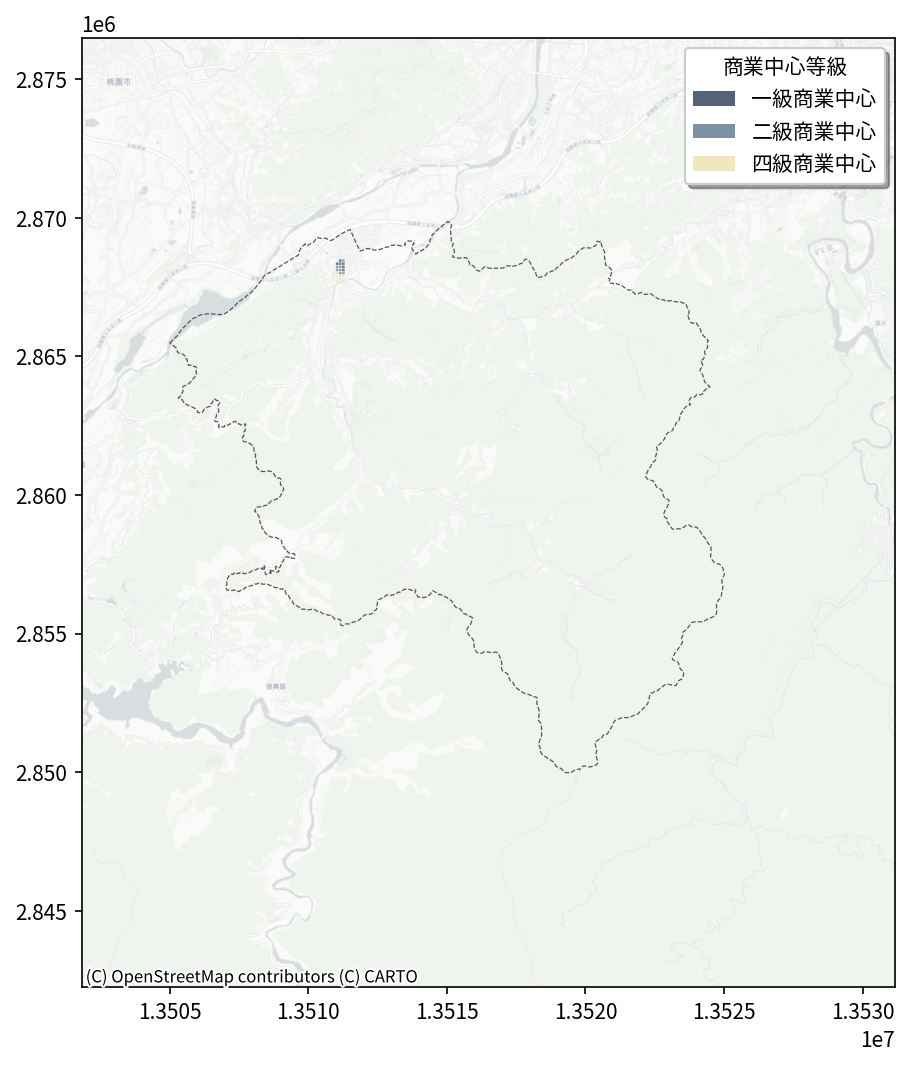

<Axes: >

In [29]:
visualizer = VisualizationManager()

selected_towns = ['三峽區']  #['三重區', '蘆洲區', ]  # '三重區', '新莊區', '蘆洲區'

# 2. 篩選商業中心資料 (Data Filtering)
# 從合併後的大表 (all_commercial_centers) 中篩選
subset_centers = all_commercial_centers[
    all_commercial_centers['TOWNNAME'].isin(selected_towns)
].copy()

# 3. 篩選行政區邊界 (Boundary Filtering)
# 從行政區大表 (map_loaded) 中篩選，作為底圖框線
subset_boundaries = map_loaded[
    (map_loaded['COUNTYNAME'] == '新北市') & 
    (map_loaded['TOWNNAME'].isin(selected_towns))
].copy()

# 確保座標系統一致 (如果你之前沒轉過，這裡保險起見再轉一次)
if subset_boundaries.crs.to_string() != 'EPSG:3826':
    subset_boundaries = subset_boundaries.to_crs('EPSG:3826')

# 4. 下繪圖參數
visualizer.visualize_map(
    commercial_centers=subset_centers,    # 只傳入篩選後的點位
    admin_boundaries=subset_boundaries,   # 只傳入篩選後的邊界
    mode='centers',                       # 模式：商業中心
    focus_target='boundary',              # 'centers' (聚焦熱點) 或 'boundary' (聚焦全行政區)
                                          # 因為只有一兩個區，聚焦在行政區邊界會比聚焦在點位更工整
    title=f"商業中心分佈特寫：{'/'.join(selected_towns)}",
    zoom=13,                              # 特寫時 zoom 可以大一點 (數字大 = 鏡頭近)
    margin=0.3                            # 留點白邊比較好看
)

In [ ]:
all_commercial_centers.dtypes

In [17]:
# 商圈分類


def classify_ljuno_from_bins(plot_data: pd.DataFrame) -> dict:
    area = plot_data.set_index("score_bin")["area_km2"]
    low = area.loc[1:3].sum()
    mid = area.loc[4:7].sum()
    high = area.loc[8:10].sum()
    total = low + mid + high

    if total == 0:
        return {"type": "NA", "reason": "total area is 0", "shares": {"low": 0.0, "mid": 0.0, "high": 0.0}}

    shares = {"low": low / total, "mid": mid / total, "high": high / total}

    if shares["high"] >= 0.45 and shares["high"] > shares["mid"]:
        return {"type": "L", "reason": "high dominates", "shares": shares}
    if (shares["low"] + shares["high"]) >= 0.70 and shares["mid"] <= 0.25:
        return {"type": "U", "reason": "two-end heavy", "shares": shares}
    if shares["mid"] >= 0.45 and shares["mid"] > shares["high"]:
        return {"type": "N", "reason": "mid dominates", "shares": shares}
    if max(shares.values()) <= 0.40:
        return {"type": "O", "reason": "balanced", "shares": shares}
    if shares["high"] > shares["mid"]:
        return {"type": "J", "reason": "high > mid but not L-threshold", "shares": shares}

    return {"type": "N", "reason": "default mid-leaning", "shares": shares}


def classify_hotspot_cohesion(plot_data: pd.DataFrame) -> dict:
    area = plot_data.set_index("score_bin")["area_km2"]
    total = area.sum()
    if total == 0:
        return {"type": "NA", "reason": "no area", "high_share": 0.0}

    high = area.loc[8:10].sum()
    mid = area.loc[4:7].sum()
    high_share = high / total
    mid_share = mid / total

    if high_share >= 0.60:
        return {"type": "高度凝聚", "reason": "high-score area dominates", "high_share": high_share}
    if high_share >= 0.40 and mid_share >= 0.25:
        return {"type": "結構型凝聚", "reason": "strong core with layers", "high_share": high_share}
    return {"type": "破碎型熱點", "reason": "core not dominant", "high_share": high_share}


def analyze_single_town_structure_compute(
    centers_df: pd.DataFrame,
    target_town: str,
    valid_levels=("一級商業中心", "二級商業中心", "三級商業中心", "四級商業中心"),
    town_col: str = "TOWNNAME",
    density_col: str = "density",
    area_col: str = "area",
    score_col: str = "score",
    log_density_col: str = "log_density",
    q_max: float = 0.999,
    recompute_score: bool = False,
    bin_method: str = "ceil",
    debug: bool = False
) -> dict:
    """
    只做計算，不畫圖。回傳 plot_data / shape / hotspot_cohesion / top_grids。
    """
    df = centers_df.loc[centers_df["center_level"].isin(valid_levels)].copy()
    if df.empty:
        raise ValueError("過濾 center_level 後 df 為空，請檢查 valid_levels 或 centers_df 欄位。")

    # 分數：優先用既有 score/log_density；必要時才重算
    if recompute_score or (score_col not in df.columns) or (log_density_col not in df.columns):
        d = df[density_col].fillna(0).clip(lower=0)
        df[log_density_col] = np.log1p(d)

        global_min_log = float(df[log_density_col].min())
        global_max_log = float(np.quantile(df[log_density_col], q_max))
        if np.isclose(global_max_log, global_min_log):
            global_max_log = global_min_log + 1e-9

        df[log_density_col] = df[log_density_col].clip(upper=global_max_log)
        df[score_col] = (
            (df[log_density_col] - global_min_log) / (global_max_log - global_min_log) * 9 + 1
        ).clip(1, 10)
    else:
        # 用現有欄位；這兩個值主要是 debug 用（這裡先保留）
        global_min_log = float(np.nanmin(df[log_density_col]))
        global_max_log = float(np.nanquantile(df[log_density_col], q_max))

    town_data = df.loc[df[town_col] == target_town].copy()
    if town_data.empty:
        return {
            "plot_data": None,
            "shape": {"type": "NA", "reason": "town not found", "shares": {"low": 0, "mid": 0, "high": 0}},
            "hotspot_cohesion": {"type": "NA", "reason": "town not found", "high_share": 0.0},
            "top_grids": None,
            "diagnostics": {"global_min_log": global_min_log, "global_max_log": global_max_log},
        }

    # 分箱
    score_vals = town_data[score_col].astype(float).clip(1, 10)
    if bin_method == "ceil":
        town_data["score_bin"] = np.ceil(score_vals).astype(int)
    elif bin_method == "round":
        town_data["score_bin"] = np.rint(score_vals).astype(int)
    elif bin_method == "floor":
        town_data["score_bin"] = np.floor(score_vals).astype(int)
    else:
        raise ValueError("bin_method must be one of: 'ceil', 'round', 'floor'")
    town_data["score_bin"] = town_data["score_bin"].clip(1, 10)

    # 面積聚合：m^2 -> km^2
    plot_data = (
        town_data.groupby("score_bin", as_index=False)[area_col]
        .sum()
        .rename(columns={area_col: "area_m2"})
    )
    plot_data = (
        pd.DataFrame({"score_bin": range(1, 11)})
        .merge(plot_data, on="score_bin", how="left")
        .fillna({"area_m2": 0.0})
    )
    plot_data["area_km2"] = plot_data["area_m2"] / 1_000_000

    shape = classify_ljuno_from_bins(plot_data)
    hotspot_cohesion = classify_hotspot_cohesion(plot_data)
    top_grids = town_data.sort_values(density_col, ascending=False).head(5)

    if debug:
        print("\n=== 數據檢查報告 ===")
        print(f"全域滿分基準 (log_density 分位數 q={q_max}): {global_max_log:.4f}")
        print(f"{target_town} log_density 最大值: {float(town_data[log_density_col].max()):.4f}")
        print(f"結構判定：{shape['type']} / {shape['reason']}")
        print(
            f"面積占比：low={shape['shares']['low']:.2%}, "
            f"mid={shape['shares']['mid']:.2%}, "
            f"high={shape['shares']['high']:.2%}"
        )

        print("\n=== 熱點凝聚度判定 ===")
        print(f"凝聚型態：{hotspot_cohesion['type']}")
        print(f"原因：{hotspot_cohesion['reason']}")
        print(f"高分區佔比：{hotspot_cohesion['high_share']:.2%}")

        print("\n密度最高的 5 個網格：")
        cols = ["grid_id", "center_id", density_col, log_density_col, score_col, "score_bin", "center_level"]
        cols = [c for c in cols if c in top_grids.columns]
        print(top_grids[cols])



    return {
        "plot_data": plot_data,
        "shape": shape,
        "hotspot_cohesion": hotspot_cohesion,
        "top_grids": top_grids,
        "diagnostics": {"global_min_log": global_min_log, "global_max_log": global_max_log},
    }


def plot_single_town_on_ax(
    ax: plt.Axes,
    plot_data: pd.DataFrame,
    title: str,
    subtitle_right: str,
    shares: dict | None = None,  # ✅ 新增：{"low":..., "mid":..., "high":...}
):
    bars = ax.bar(
        plot_data["score_bin"],
        plot_data["area_km2"],
        width=1.0,
        edgecolor="white",
        linewidth=0.8,
    )

    ax.set_xticks([1, 5, 10])
    ax.set_xticklabels(["1\n低", "5\n中", "10\n頂"], fontsize=9)
    ax.set_xlim(0.5, 10.5)
    ax.grid(axis="y", linestyle="--", alpha=0.3)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax.set_title(title, fontsize=12, fontweight="bold", loc="left")
    ax.text(0.99, 1.02, subtitle_right, transform=ax.transAxes, ha="right", color="gray", fontsize=9)

    # ✅ 在子圖右上角顯示 low/mid/high 面積占比
    if shares is not None:
        txt = (
            f"low  {shares['low']*100:>5.1f}%\n"
            f"mid  {shares['mid']*100:>5.1f}%\n"
            f"high {shares['high']*100:>5.1f}%"
        )
        ax.text(
            0.99, 0.88, txt,
            transform=ax.transAxes,
            ha="right", va="top",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", alpha=0.10)  # 淡淡的底避免看不清
        )

    # 小圖避免太擠：只標最大值附近的 bar
    max_h = plot_data["area_km2"].max()
    for b in bars:
        h = b.get_height()
        if h > 0 and h >= max_h * 0.25:
            ax.text(b.get_x() + b.get_width() / 2, h, f"{h:.2f}", ha="center", va="bottom", fontsize=8)

    return float(plot_data["area_km2"].sum())


def build_summary_table(results: dict) -> pd.DataFrame:
    """
    results: { town_name: res_dict }，其中 res_dict 為 analyze_single_town_structure_compute 的回傳
    回傳：每個行政區一列的 summary DataFrame
    """
    rows = []
    for town, res in results.items():
        if res is None or res.get("plot_data") is None:
            rows.append({
                "行政區": town,
                "結構型態": "NA",
                "凝聚型態": "NA",
                "總面積_km2": 0.0,
                "low_%": 0.0,
                "mid_%": 0.0,
                "high_%": 0.0,
                "high_share_%": 0.0,
            })
            continue

        plot_data = res["plot_data"]
        shape = res["shape"]
        cohesion = res["hotspot_cohesion"]

        total_area = float(plot_data["area_km2"].sum())
        low_pct = float(shape["shares"]["low"] * 100)
        mid_pct = float(shape["shares"]["mid"] * 100)
        high_pct = float(shape["shares"]["high"] * 100)
        high_share_pct = float(cohesion.get("high_share", 0.0) * 100)

        rows.append({
            "行政區": town,
            "結構型態": shape["type"],
            "凝聚型態": cohesion["type"],
            "總面積_km2": total_area,
            "low_%": low_pct,
            "mid_%": mid_pct,
            "high_%": high_pct,
            "high_share_%": high_share_pct,
        })

    df = pd.DataFrame(rows)

    # 常用排序：先看總面積大、再看 high_share 高
    df = df.sort_values(["總面積_km2", "high_share_%"], ascending=[False, False]).reset_index(drop=True)
    return df


def plot_multiple_towns_structure(
    centers_df: pd.DataFrame,
    towns: list,
    ncols: int = 2,
    figsize_per_ax=(6.0, 4.2),
    recompute_score: bool = False,
    bin_method: str = "ceil",
    q_max: float = 0.999,
    debug=False,  # False | True | list[str]
):
    """
    一張大圖放多個子圖：一次跑多個行政區
    回傳：(fig, results_dict)
    """
    n = len(towns)
    nrows = math.ceil(n / ncols)
    fig_w = figsize_per_ax[0] * ncols
    fig_h = figsize_per_ax[1] * nrows

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h), dpi=150)
    axes = np.array(axes).reshape(-1)  # 攤平成一維好處理

    # debug 控制：True=全印；list=只印指定；False=不印
    debug_set = set(towns) if debug is True else (set(debug) if isinstance(debug, (list, tuple, set)) else set())

    results = {}
    for i, town in enumerate(towns):
        ax = axes[i]

        res = analyze_single_town_structure_compute(
            centers_df,
            target_town=town,
            recompute_score=recompute_score,
            bin_method=bin_method,
            q_max=q_max,
            debug=(town in debug_set),  # ✅ 把 debug 往下傳
        )
        results[town] = res

        if res["plot_data"] is None:
            ax.set_title(f"{town}（無資料）", loc="left", fontsize=12, fontweight="bold")
            ax.axis("off")
            continue

        shape = res["shape"]
        cohesion = res["hotspot_cohesion"]

        title = f"{town}｜{shape['type']} 型 × {cohesion['type']}"
        total_area = float(res["plot_data"]["area_km2"].sum())
        subtitle_right = f"總面積 {total_area:.2f} km²"

        plot_single_town_on_ax(
            ax=ax,
            plot_data=res["plot_data"],
            title=title,
            subtitle_right=subtitle_right,
            shares=res["shape"]["shares"],
        )

        if i % ncols == 0:
            ax.set_ylabel("商業區面積 (km²)", fontsize=10, fontweight="bold", color="#555555")

        if i // ncols == (nrows - 1):
            ax.set_xlabel("標準化商業資源指數 (1-10)", fontsize=10, fontweight="bold", color="#555555")

    for j in range(n, len(axes)):
        axes[j].axis("off")

    fig.suptitle("多行政區商業結構指紋圖（同一尺度比較）", fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()

    summary_df = build_summary_table(results)
    return fig, results, summary_df



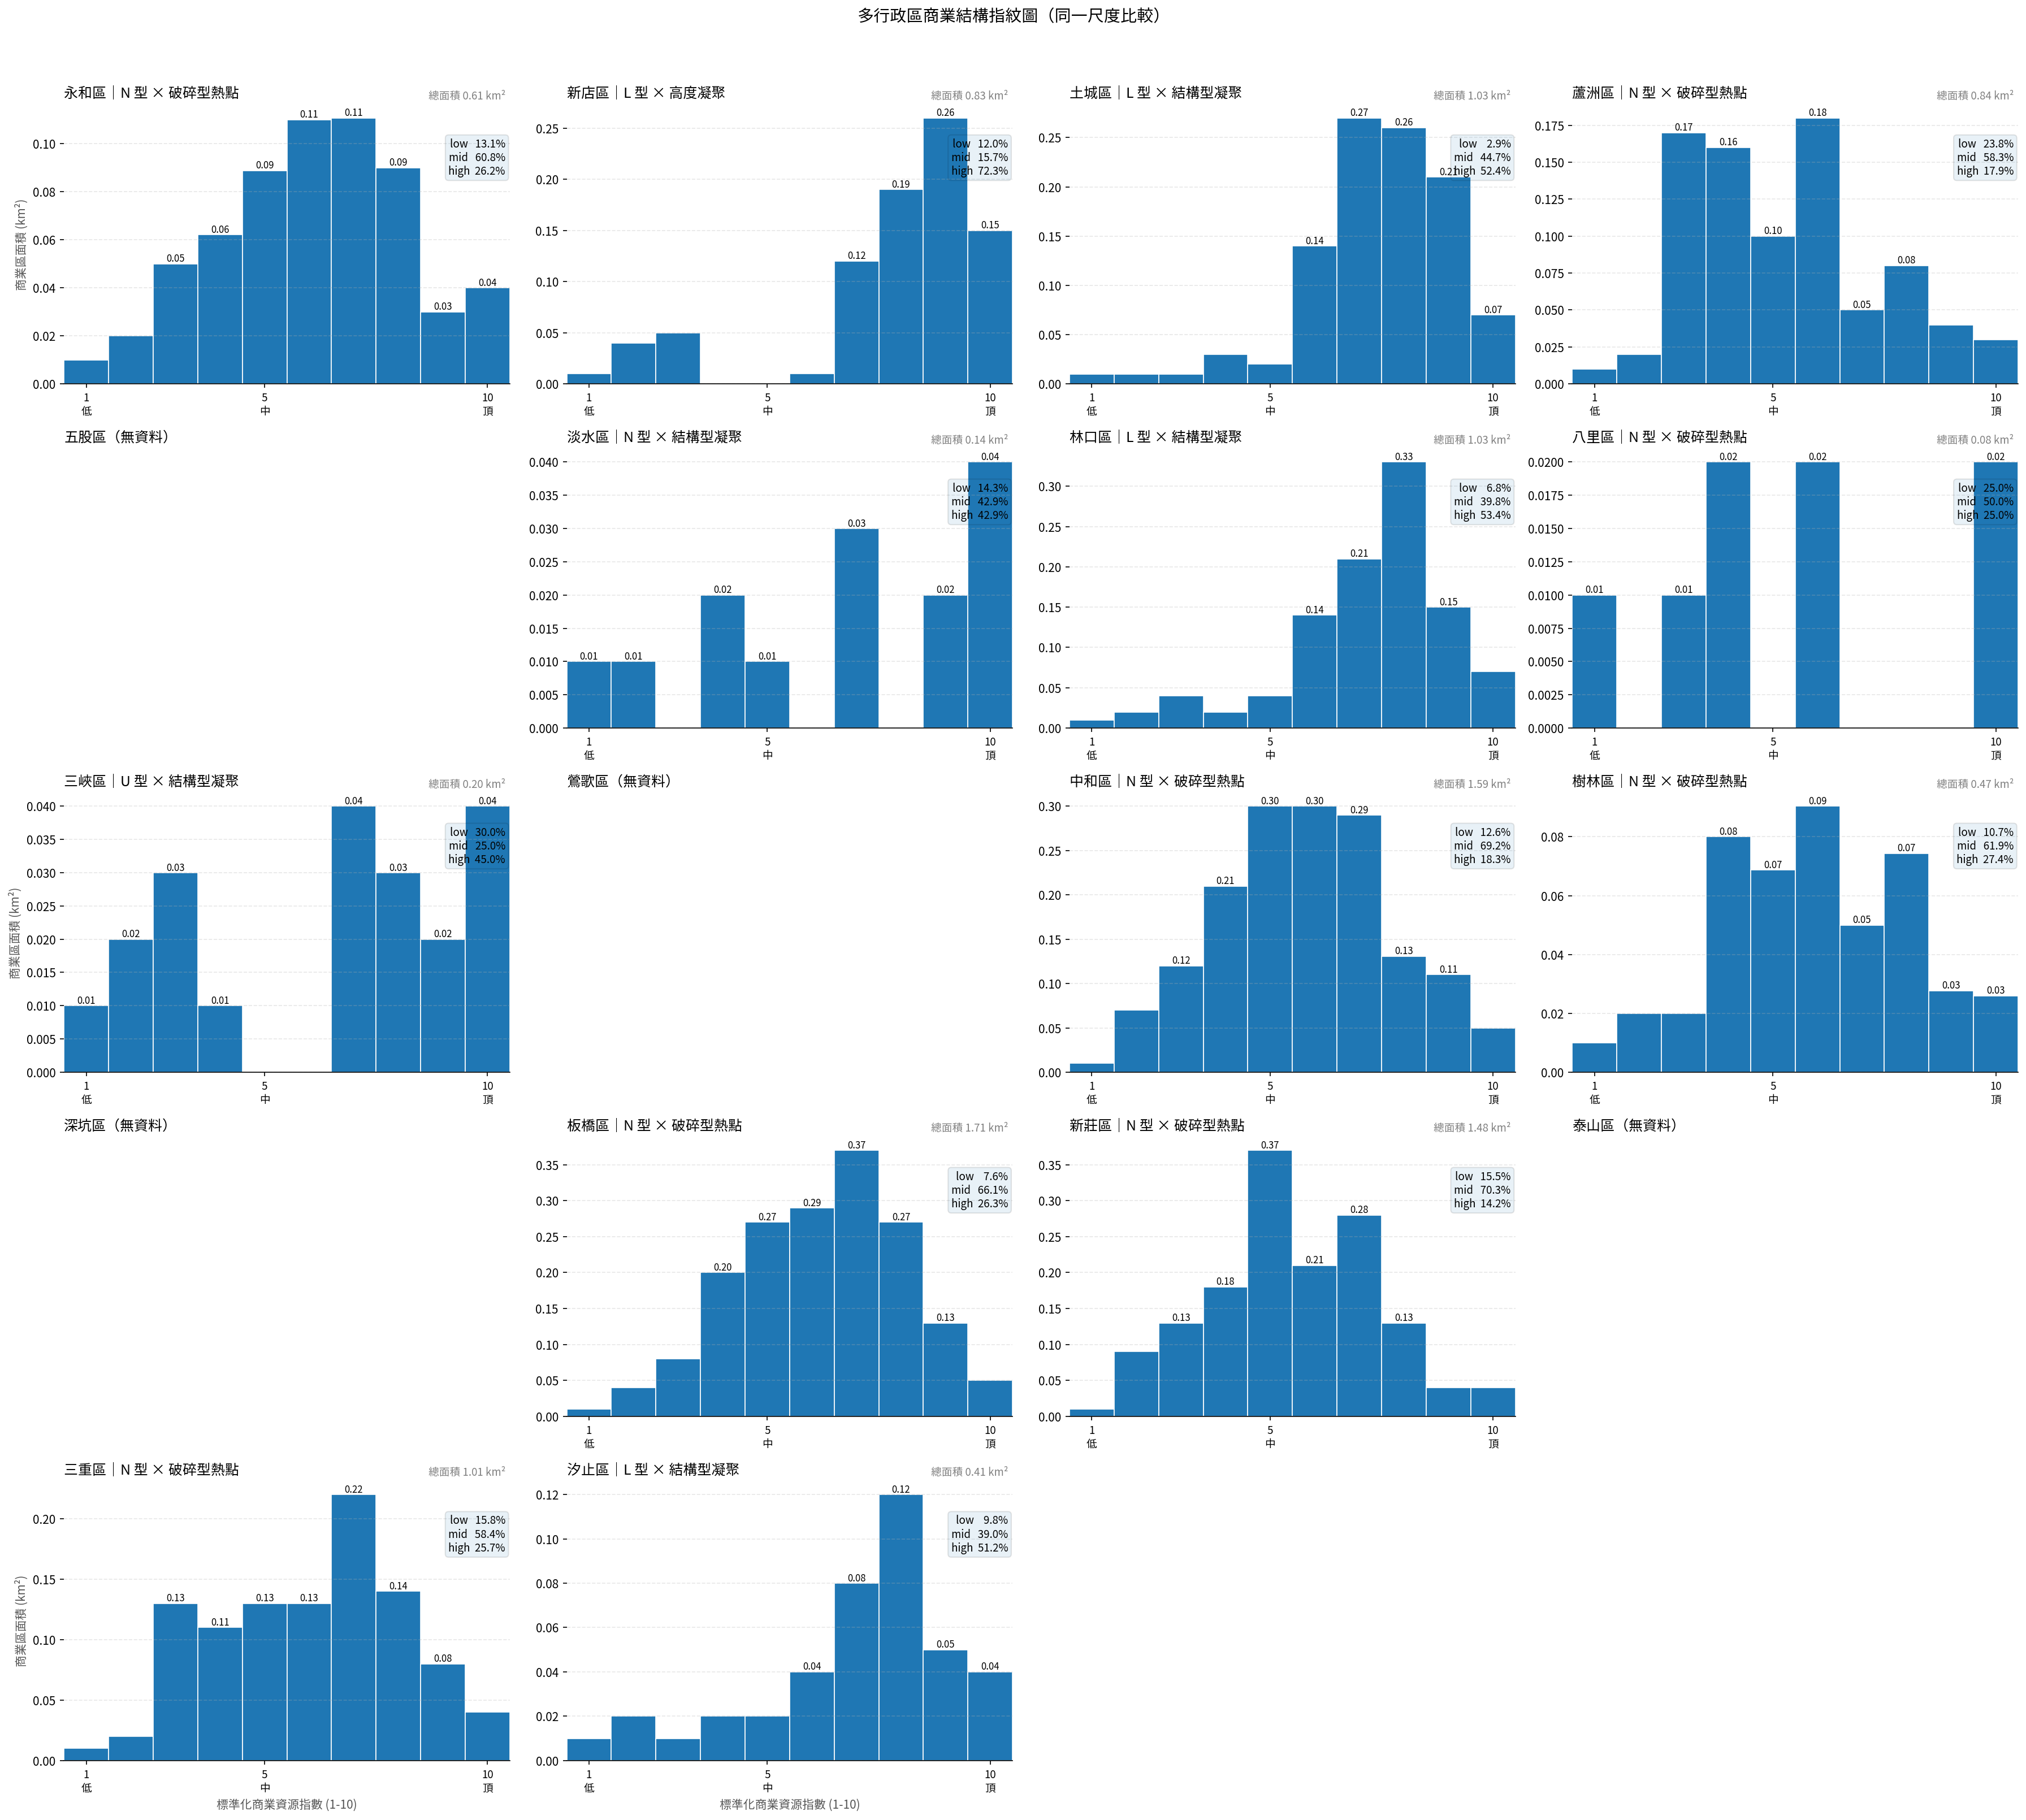

,行政區,結構型態,凝聚型態,總面積_km2,low_%,mid_%,high_%,high_share_%
0,板橋區,N,破碎型熱點,1.710000,7.602339,66.081871,26.315789,26.315789
1,中和區,N,破碎型熱點,1.590673,12.573291,69.153101,18.273608,18.273608
2,新莊區,N,破碎型熱點,1.480000,15.540541,70.270270,14.189189,14.189189
3,林口區,L,結構型凝聚,1.030000,6.796117,39.805825,53.398058,53.398058
4,土城區,L,結構型凝聚,1.030000,2.912621,44.660194,52.427184,52.427184
5,三重區,N,破碎型熱點,1.010000,15.841584,58.415842,25.742574,25.742574
6,蘆洲區,N,破碎型熱點,0.840000,23.809524,58.333333,17.857143,17.857143
7,新店區,L,高度凝聚,0.830000,12.048193,15.662651,72.289157,72.289157
8,永和區,N,破碎型熱點,0.611679,13.078762,60.763713,26.157525,26.157525
9,樹林區,N,破碎型熱點,0.467146,10.703303,61.886227,27.410471,27.410471


In [18]:
# =========================
# 使用範例：一次畫 三重區、蘆洲區 在同一張大圖
# =========================
fig, results ,summary_df= plot_multiple_towns_structure(
    all_commercial_centers,
    towns=TARGET_TOWNS,
    ncols=4,
    recompute_score=False,  # 你資料已有 score/log_density → 建議 False
    bin_method="ceil",
    debug=False,  # True | False | ["三重區"] (只印三重區的 debug)
)

# results["三重區"]["shape"]
# results["蘆洲區"]["hotspot_cohesion"]

summary_df

## 下述是原可用程式碼，先保留待上述測試完再檢視是否保留

In [ ]:
# === 資料載入 ===
print("=== 開始載入資料 ===\n")

# 讀取方格網格資料
save_path_grid = r"C:\labs\geo-grid\data\output_grids\grids_100m\Grid_新北市_100m.parquet"
grid_loaded = gpd.read_parquet(save_path_grid)
print(f"✓ 網格資料載入完成: {len(grid_loaded)} 個網格")

# 讀取地圖資料
save_path_map = r"C:\labs\geo-grid\data\output_grids\grids_100m\gdf_tm2.parquet"
map_loaded = gpd.read_parquet(save_path_map)
print(f"✓ 地圖資料載入完成: {len(map_loaded)} 筆行政區")

# 讀取餐飲業POI資料
save_path_gdf = r"C:\labs\geo-grid\data\output_poi\catering_gdf.parquet"
catering_loaded = gpd.read_parquet(save_path_gdf)
print(f"✓ 餐飲POI載入完成: {len(catering_loaded)} 筆")

# 篩選分析區域 POI
catering_anlyzed = catering_loaded.loc[catering_loaded['行政區'] == TARGET_TOWN].copy()
print(f"✓ 篩選{TARGET_TOWN}POI: {len(catering_anlyzed)} 筆\n")

print("所有資料載入完成！")

In [ ]:
# ==========================================
# 數據預處理 (Data Preprocessing)
# ==========================================

# 1. 鎖定分析範圍 (取得三重區的邊界幾何)
target_boundary = map_loaded[
    (map_loaded['COUNTYNAME'] == TARGET_COUNTY) & 
    (map_loaded['TOWNNAME'] == TARGET_TOWN)
].copy()

# 確保座標系統一致轉換為 Web Mercator (EPSG:3857) 
# Class 內部的距離計算依賴 EPSG:3857 (以公尺為單位)
if target_boundary.crs.to_string() != 'EPSG:3826':
    target_boundary = target_boundary.to_crs('EPSG:3826')

if catering_anlyzed.crs.to_string() != 'EPSG:3826':
    catering_anlyzed = catering_anlyzed.to_crs('EPSG:3826')
if grid_loaded.crs.to_string() != 'EPSG:3826':
    grid_loaded = grid_loaded.to_crs('EPSG:3826')

# 2. 篩選目標區域的網格 (非常重要！)
# 你的 grid_loaded 是全部分區，必須只切出三重區的網格，
# 否則 Moran's I 計算時，周圍大量空白網格會導致統計偏誤。
print(f"正在篩選 {TARGET_TOWN} 的網格...")
grid_analyzed = gpd.overlay(grid_loaded, target_boundary, how='intersection')

# 重新計算切割後的面積並篩除過小碎片
grid_analyzed['area'] = grid_analyzed.geometry.area
min_area_threshold = (100 * 100) * 0.1  # 假設網格是100m，取10%為閾值
grid_analyzed = grid_analyzed[grid_analyzed['area'] > min_area_threshold].reset_index(drop=True)

print(f"✓ {TARGET_TOWN} 分析網格數量: {len(grid_analyzed)}")

# ==========================================
# 初始化與執行分析 (Execution)
# ==========================================

# 1. 初始化分析器 (設定網格大小為 100m)
identifier = CommercialCenterIdentifier(cell_size=100)

# 2. 設定餐飲業權重
# 由於你的數據是「餐飲業」，原本的便利商店/超市權重不適用。
# 你需要檢查 catering_anlyzed 中是否有分類欄位。
# 假設沒有細分，我們給予所有餐飲點位相同的權重 1.0，或者你可以根據資本額或類別設定
catering_weights = weights

# 為了讓程式順利運行，如果資料中沒有 'type' 欄位，我們手動加上一個預設值
if 'type' not in catering_anlyzed.columns:
    catering_anlyzed['type'] = 'default'

# 3. 步驟一：計算核密度 (Kernel Density)
print("\n--- 步驟 1: 計算核密度 ---")
grid_with_density = identifier.calculate_kernel_density(
    poi_data=catering_anlyzed,
    grid_df=grid_analyzed,
    weights=catering_weights
)

# 4. 步驟二：計算 Moran's I (空間自相關)
print("\n--- 步驟 2: 空間自相關分析 ---")
moran_res, grid_with_moran = identifier.calculate_morans_i(
    grid_df=grid_with_density,
    weight_type='queen' # 使用 Queen 接鄰關係
)

# 5. 步驟三：熱點分析 (Hotspot Analysis)
print("\n--- 步驟 3: 熱點分析 ---")
grid_with_hotspot = identifier.perform_hotspot_analysis(
    grid_df=grid_with_moran
)

# 6. 步驟四：識別商業中心
print("\n--- 步驟 4: 識別商業中心 ---")
# threshold_percentile 可以根據需要調整，例如 80 或 85
commercial_centers = identifier.identify_commercial_centers(
    grid_df=grid_with_hotspot,
    threshold_percentile=80,
    group_col='TOWNNAME'
)



In [ ]:
commercial_centers.columns

In [ ]:
visualizer = VisualizationManager()

visualizer.visualize_map(
    commercial_centers=commercial_centers, # 必須給商業中心
    admin_boundaries=target_boundary,
    focus_target='centers',        # <--- 'centers' (聚焦熱點) 或 'boundary' (聚焦全行政區)
    margin=.4,                         # <--- 增加留白
    mode='centers',                # <--- 指定模式
    title=f"{TARGET_TOWN} 識別出的商業中心等級",
    zoom=14,
    basemap_style='light',             # 'light', 'dark', 'warm', 'detail'
    # save_path="output_centers_map.png"
)

In [ ]:
visualizer.visualize_map(
    commercial_centers=commercial_centers,
    grid_df=grid_with_hotspot,  # <--- 這一行一定要有！
    admin_boundaries=target_boundary,
    mode='all',
    focus_target='boundary',
)

In [ ]:

visualizer.visualize_map(
    grid_df=grid_with_hotspot,      # 必須給網格
    admin_boundaries=target_boundary,
    mode='density',                 # <--- 指定模式
    title=f"{TARGET_TOWN} 餐飲業密度分佈",
    # save_path="output_density_map.png"
)